In [1]:
import numpy as np

In [2]:
import pandas as pd

In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [4]:
!pip install catboost

In [5]:
!pip install pmdarima

In [6]:
import os
import math

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import KFold
from catboost import CatBoostRegressor
plt.style.use('fivethirtyeight')
from sklearn.model_selection import GridSearchCV
import pylab 

In [8]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from scipy.special import boxcox, inv_boxcox
from scipy import stats
from pmdarima import auto_arima
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings('ignore')

In [9]:
train = pd.read_csv('train_IxoE5JN 6.csv')
test  = pd.read_csv('greenenergy.csv')

In [10]:
print(train)
print(test)

       row_id             datetime       energy
0           1  2008-03-01 00:00:00  1259.985563
1           2  2008-03-01 01:00:00  1095.541500
2           3  2008-03-01 02:00:00  1056.247500
3           4  2008-03-01 03:00:00  1034.742000
4           5  2008-03-01 04:00:00  1026.334500
...       ...                  ...          ...
94987   94988  2018-12-31 19:00:00  2528.446800
94988   94989  2018-12-31 20:00:00  2461.883600
94989   94990  2018-12-31 21:00:00  2365.994400
94990   94991  2018-12-31 22:00:00  2342.942800
94991   94992  2018-12-31 23:00:00  2180.217600

[94992 rows x 3 columns]
       row_id       energy
0       94993  2168.121739
1       94994  2155.336002
2       94995  2145.327078
3       94996  2140.640190
4       94997  2142.297833
...       ...          ...
26299  121292  2163.551256
26300  121293  2163.551256
26301  121294  2163.551256
26302  121295  2163.551256
26303  121296  2163.551256

[26304 rows x 2 columns]


In [11]:
print("Training data shape : ",train.shape)
print("Test data shape : ",test.shape)

Training data shape :  (94992, 3)
Test data shape :  (26304, 2)


In [12]:
train.isnull().sum()

row_id         0
datetime       0
energy      1900
dtype: int64

In [13]:
test.isnull().sum()


row_id    0
energy    0
dtype: int64

In [14]:
train['energy']= train['energy'].replace(0,train['energy'].mean())

In [15]:
df1 = train.isnull().sum()

In [16]:
train.describe()

row_id        energy
count  94992.000000  93092.000000
mean   47496.500000   1702.995014
std    27421.972723    369.322103
min        1.000000    866.388600
25%    23748.750000   1431.541100
50%    47496.500000   1654.465800
75%    71244.250000   1935.993450
max    94992.000000   3374.399600

In [17]:
tr = pd.isna(train['energy']).count
tr

<bound method Series.count of 0        False
1        False
2        False
3        False
4        False
         ...  
94987    False
94988    False
94989    False
94990    False
94991    False
Name: energy, Length: 94992, dtype: bool>

In [18]:
train.datetime

0        2008-03-01 00:00:00
1        2008-03-01 01:00:00
2        2008-03-01 02:00:00
3        2008-03-01 03:00:00
4        2008-03-01 04:00:00
                ...         
94987    2018-12-31 19:00:00
94988    2018-12-31 20:00:00
94989    2018-12-31 21:00:00
94990    2018-12-31 22:00:00
94991    2018-12-31 23:00:00
Name: datetime, Length: 94992, dtype: object

In [19]:
train['date'] = pd.to_datetime(train['datetime']).dt.date
train['Hour'] = pd.to_datetime(train['datetime']).dt.hour
print(train)
print(train.dtypes)

       row_id             datetime       energy        date  Hour
0           1  2008-03-01 00:00:00  1259.985563  2008-03-01     0
1           2  2008-03-01 01:00:00  1095.541500  2008-03-01     1
2           3  2008-03-01 02:00:00  1056.247500  2008-03-01     2
3           4  2008-03-01 03:00:00  1034.742000  2008-03-01     3
4           5  2008-03-01 04:00:00  1026.334500  2008-03-01     4
...       ...                  ...          ...         ...   ...
94987   94988  2018-12-31 19:00:00  2528.446800  2018-12-31    19
94988   94989  2018-12-31 20:00:00  2461.883600  2018-12-31    20
94989   94990  2018-12-31 21:00:00  2365.994400  2018-12-31    21
94990   94991  2018-12-31 22:00:00  2342.942800  2018-12-31    22
94991   94992  2018-12-31 23:00:00  2180.217600  2018-12-31    23

[94992 rows x 5 columns]
row_id        int64
datetime     object
energy      float64
date         object
Hour          int64
dtype: object


In [20]:
df = train.copy()
df


row_id             datetime       energy        date  Hour
0           1  2008-03-01 00:00:00  1259.985563  2008-03-01     0
1           2  2008-03-01 01:00:00  1095.541500  2008-03-01     1
2           3  2008-03-01 02:00:00  1056.247500  2008-03-01     2
3           4  2008-03-01 03:00:00  1034.742000  2008-03-01     3
4           5  2008-03-01 04:00:00  1026.334500  2008-03-01     4
...       ...                  ...          ...         ...   ...
94987   94988  2018-12-31 19:00:00  2528.446800  2018-12-31    19
94988   94989  2018-12-31 20:00:00  2461.883600  2018-12-31    20
94989   94990  2018-12-31 21:00:00  2365.994400  2018-12-31    21
94990   94991  2018-12-31 22:00:00  2342.942800  2018-12-31    22
94991   94992  2018-12-31 23:00:00  2180.217600  2018-12-31    23

[94992 rows x 5 columns]

In [21]:
# Creating filter
df_filter = df.isin([np.nan, np.inf, -np.inf])
  
# Masking df with the filter
df = df[~df_filter]
  
# Dropping rows with nan values
df.dropna(inplace=True)
  
# Printing df
df

row_id             datetime       energy        date  Hour
0           1  2008-03-01 00:00:00  1259.985563  2008-03-01     0
1           2  2008-03-01 01:00:00  1095.541500  2008-03-01     1
2           3  2008-03-01 02:00:00  1056.247500  2008-03-01     2
3           4  2008-03-01 03:00:00  1034.742000  2008-03-01     3
4           5  2008-03-01 04:00:00  1026.334500  2008-03-01     4
...       ...                  ...          ...         ...   ...
94987   94988  2018-12-31 19:00:00  2528.446800  2018-12-31    19
94988   94989  2018-12-31 20:00:00  2461.883600  2018-12-31    20
94989   94990  2018-12-31 21:00:00  2365.994400  2018-12-31    21
94990   94991  2018-12-31 22:00:00  2342.942800  2018-12-31    22
94991   94992  2018-12-31 23:00:00  2180.217600  2018-12-31    23

[93092 rows x 5 columns]

In [22]:
df.dtypes

row_id        int64
datetime     object
energy      float64
date         object
Hour          int64
dtype: object

In [23]:
# extracting date feature

df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].apply(lambda x: x.year)
df['month'] = df['date'].apply(lambda x: x.month)
df['day'] = df['date'].apply(lambda x: x.day)
df['day_of_week'] = df['date'].apply(lambda x: x.dayofweek)
df['is_quarter_date'] = df['date'].apply(lambda x: x.quarter)
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x>4 else 0)

df.drop(['date'], axis=1, inplace=True)

In [24]:
df

row_id             datetime       energy  Hour  year  month  day  \
0           1  2008-03-01 00:00:00  1259.985563     0  2008      3    1   
1           2  2008-03-01 01:00:00  1095.541500     1  2008      3    1   
2           3  2008-03-01 02:00:00  1056.247500     2  2008      3    1   
3           4  2008-03-01 03:00:00  1034.742000     3  2008      3    1   
4           5  2008-03-01 04:00:00  1026.334500     4  2008      3    1   
...       ...                  ...          ...   ...   ...    ...  ...   
94987   94988  2018-12-31 19:00:00  2528.446800    19  2018     12   31   
94988   94989  2018-12-31 20:00:00  2461.883600    20  2018     12   31   
94989   94990  2018-12-31 21:00:00  2365.994400    21  2018     12   31   
94990   94991  2018-12-31 22:00:00  2342.942800    22  2018     12   31   
94991   94992  2018-12-31 23:00:00  2180.217600    23  2018     12   31   

       day_of_week  is_quarter_date  is_weekend  
0                5                1           1  
1                5                1           1  
2                5                1           1  
3                5                1           1  
4                5                1           1  
...            ...              ...         ...  
94987            0                4           0  
94988            0                4           0  
94989            0                4           0  
94990            0                4           0  
94991            0                4           0  

[93092 rows x 10 columns]

In [25]:
def time_of_day(n):
    if n in range(4,8):
        return 'Early Morning'
    elif n in range(8,12):
        return 'Morning'
    elif n in range(12,18):
        return 'Afternoon'
    elif n in range(18,21):
        return 'Evening'
    elif n in range(21,25) or n==0:
        return 'Night'
    elif n in range(1,4):
        return 'Late Night'
    
df['Type_of_Day'] = df['Hour'].apply(lambda x: time_of_day(x))

In [26]:
df

row_id             datetime       energy  Hour  year  month  day  \
0           1  2008-03-01 00:00:00  1259.985563     0  2008      3    1   
1           2  2008-03-01 01:00:00  1095.541500     1  2008      3    1   
2           3  2008-03-01 02:00:00  1056.247500     2  2008      3    1   
3           4  2008-03-01 03:00:00  1034.742000     3  2008      3    1   
4           5  2008-03-01 04:00:00  1026.334500     4  2008      3    1   
...       ...                  ...          ...   ...   ...    ...  ...   
94987   94988  2018-12-31 19:00:00  2528.446800    19  2018     12   31   
94988   94989  2018-12-31 20:00:00  2461.883600    20  2018     12   31   
94989   94990  2018-12-31 21:00:00  2365.994400    21  2018     12   31   
94990   94991  2018-12-31 22:00:00  2342.942800    22  2018     12   31   
94991   94992  2018-12-31 23:00:00  2180.217600    23  2018     12   31   

       day_of_week  is_quarter_date  is_weekend    Type_of_Day  
0                5                1           1          Night  
1                5                1           1     Late Night  
2                5                1           1     Late Night  
3                5                1           1     Late Night  
4                5                1           1  Early Morning  
...            ...              ...         ...            ...  
94987            0                4           0        Evening  
94988            0                4           0        Evening  
94989            0                4           0          Night  
94990            0                4           0          Night  
94991            0                4           0          Night  

[93092 rows x 11 columns]

In [27]:
def month2seasons(x):
    if x in [9, 10, 11]:
        season = 'Spring'
    elif x in [12, 1, 2]:
        season = 'Summer'
    elif x in [3, 4, 5]:
        season = 'Autumn'
    elif x in [6, 7, 8]:
        season = 'Winter'
    return season

df['Season'] = df['month'].apply(month2seasons)

In [28]:
print(df)

       row_id             datetime       energy  Hour  year  month  day  \
0           1  2008-03-01 00:00:00  1259.985563     0  2008      3    1   
1           2  2008-03-01 01:00:00  1095.541500     1  2008      3    1   
2           3  2008-03-01 02:00:00  1056.247500     2  2008      3    1   
3           4  2008-03-01 03:00:00  1034.742000     3  2008      3    1   
4           5  2008-03-01 04:00:00  1026.334500     4  2008      3    1   
...       ...                  ...          ...   ...   ...    ...  ...   
94987   94988  2018-12-31 19:00:00  2528.446800    19  2018     12   31   
94988   94989  2018-12-31 20:00:00  2461.883600    20  2018     12   31   
94989   94990  2018-12-31 21:00:00  2365.994400    21  2018     12   31   
94990   94991  2018-12-31 22:00:00  2342.942800    22  2018     12   31   
94991   94992  2018-12-31 23:00:00  2180.217600    23  2018     12   31   

       day_of_week  is_quarter_date  is_weekend    Type_of_Day  Season  
0                5        

In [29]:
df['Type_of_Day'].replace({0:'Afternoon',1 :'Morning', 2:'Night', 3:'Evening', 4:'Early Morning', 5:'Late Night'}, 
                          inplace=True)
df['Season'].replace({0:'spring', 1:'Summer', 2:'Autumn', 3:'Winter'}, inplace=True)


<AxesSubplot:xlabel='Hour', ylabel='energy'>

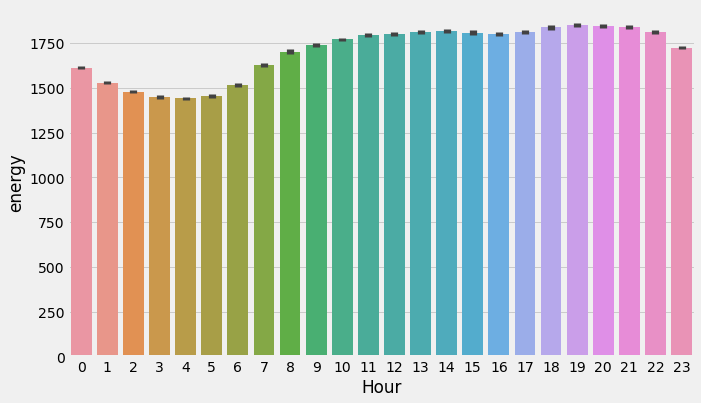

In [30]:
plt.figure(figsize=(10,6))
sns.barplot(x=df['Hour'], y=df['energy'])

<AxesSubplot:xlabel='Season', ylabel='energy'>

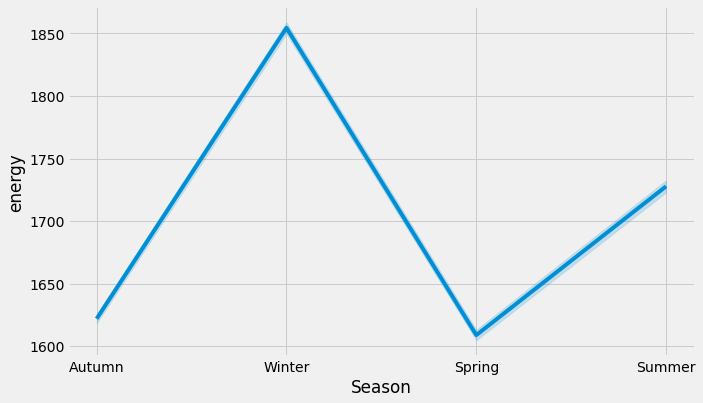

In [31]:
plt.figure(figsize=(10,6))
sns.lineplot(x=df['Season'], y=df['energy'])

<AxesSubplot:xlabel='Type_of_Day', ylabel='energy'>

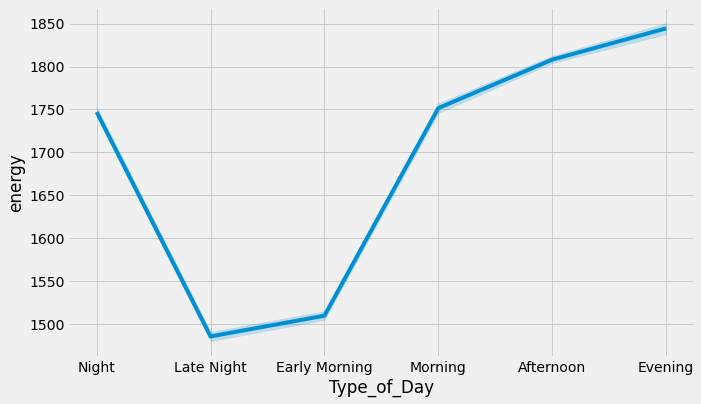

In [32]:
plt.figure(figsize=(10,6))
sns.lineplot(x=df['Type_of_Day'], y=df['energy'])

<AxesSubplot:xlabel='year', ylabel='energy'>

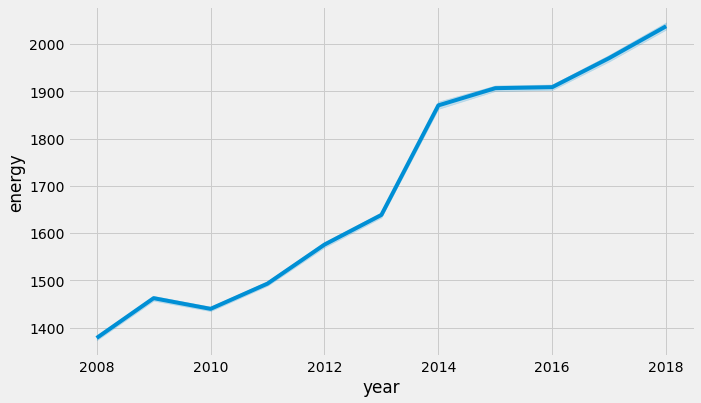

In [33]:
plt.figure(figsize=(10,6))
sns.lineplot(x=df['year'], y=df['energy'])


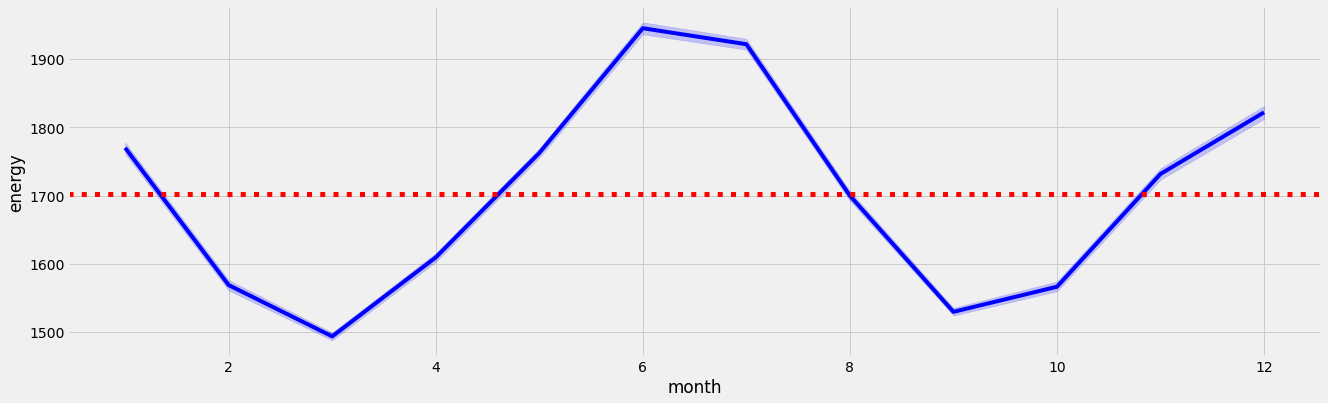

In [34]:
plt.figure(figsize=(20,6))
month=sns.lineplot(x=df['month'],y=df['energy'],color="Blue")
month.axhline(df.groupby('month')['energy'].agg({'mean'}).mean()[0],
          ls=":",color="Red",lw=5,label='Average');


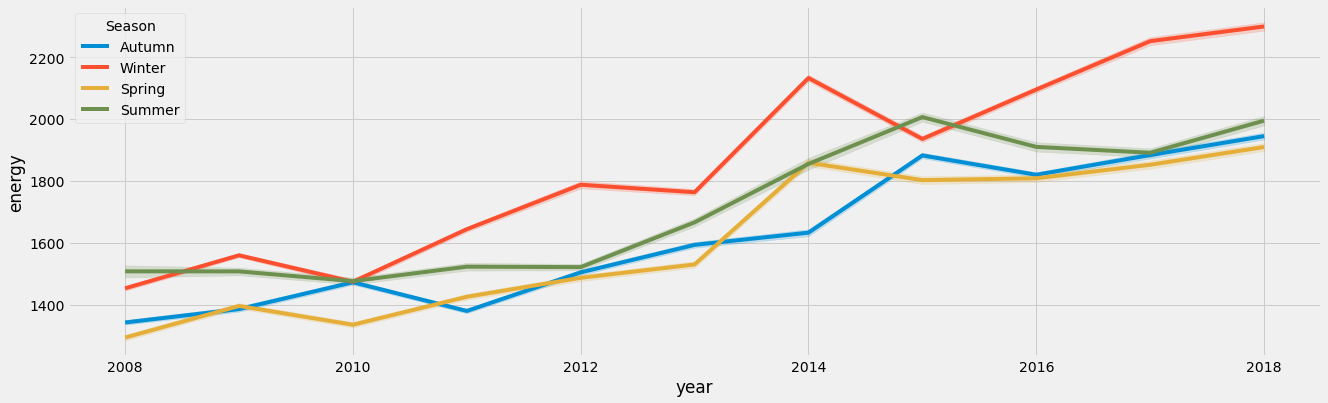

In [35]:
plt.figure(figsize=(20,6))
_=sns.lineplot(x=df['year'],y=df['energy'],hue=df['Season'])


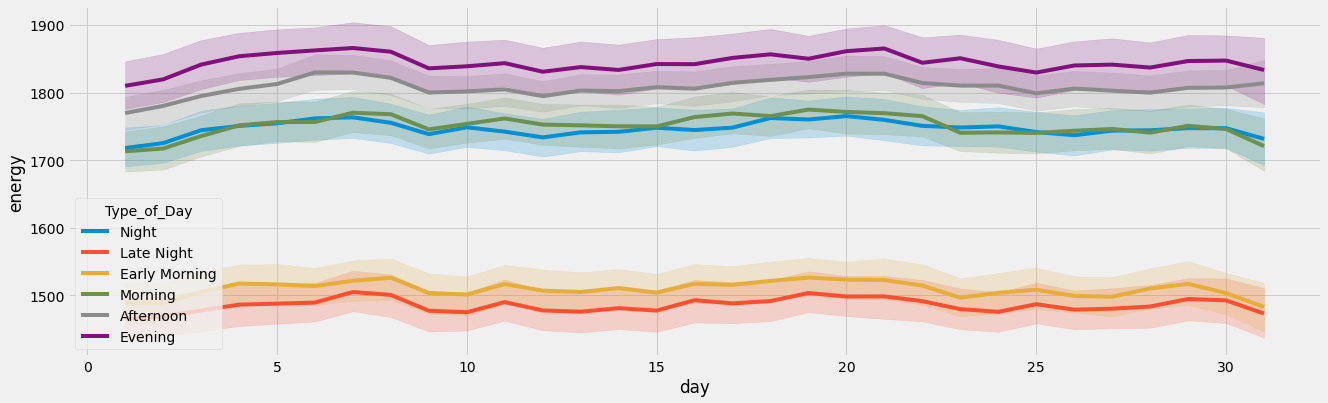

In [36]:
plt.figure(figsize=(20,6))
_=sns.lineplot(x=df['day'],y=df['energy'],hue=df['Type_of_Day'])       

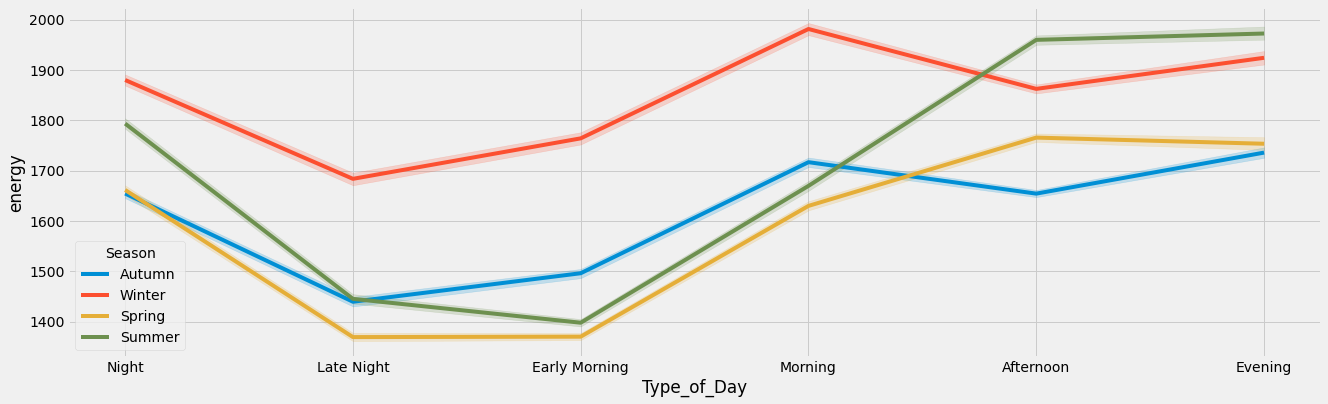

In [37]:
plt.figure(figsize=(20,6))
_=sns.lineplot(x=df['Type_of_Day'],y=df['energy'],hue=df['Season']) 

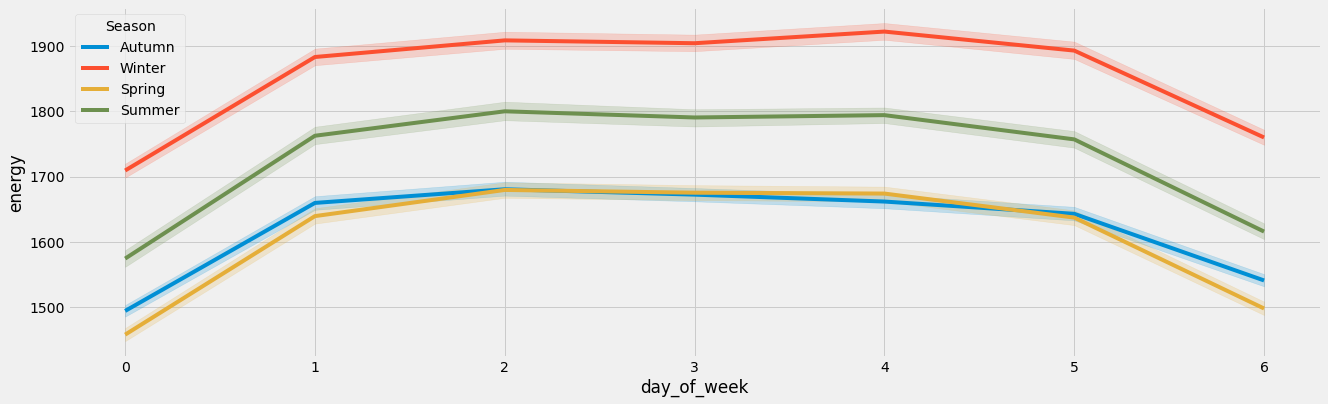

In [38]:
plt.figure(figsize=(20,6))
_=sns.lineplot(x=df['day_of_week'],y=df['energy'],hue=df['Season']) 

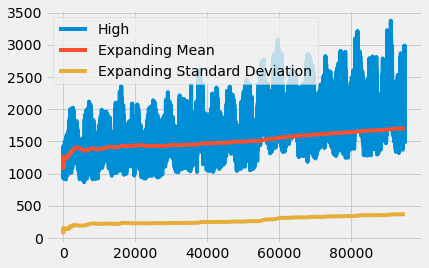

In [39]:
energy_mean = df.energy.expanding().mean()
energy_std = df.energy.expanding().std()
df.energy.plot()
energy_mean.plot()
energy_std.plot()
plt.legend(['High','Expanding Mean','Expanding Standard Deviation'])
plt.show()


In [40]:
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index("datetime", inplace= True)

In [41]:
df1 = df.resample("D").mean()

In [42]:
df1

row_id       energy       Hour    year  month   day  \
datetime                                                                
2008-03-01     12.500000  1264.005398  11.500000  2008.0    3.0   1.0   
2008-03-02     36.500000  1150.488938  11.500000  2008.0    3.0   2.0   
2008-03-03     60.500000  1082.096875  11.500000  2008.0    3.0   3.0   
2008-03-04     84.130435  1260.189978  11.130435  2008.0    3.0   4.0   
2008-03-05    108.500000  1277.914188  11.500000  2008.0    3.0   5.0   
...                  ...          ...        ...     ...    ...   ...   
2018-12-27  94884.500000  2477.131983  11.500000  2018.0   12.0  27.0   
2018-12-28  94908.500000  2381.509900  11.500000  2018.0   12.0  28.0   
2018-12-29  94932.500000  2234.698033  11.500000  2018.0   12.0  29.0   
2018-12-30  94956.500000  2004.926550  11.500000  2018.0   12.0  30.0   
2018-12-31  94980.500000  2002.238333  11.500000  2018.0   12.0  31.0   

            day_of_week  is_quarter_date  is_weekend  
datetime                                              
2008-03-01          5.0              1.0         1.0  
2008-03-02          6.0              1.0         1.0  
2008-03-03          0.0              1.0         0.0  
2008-03-04          1.0              1.0         0.0  
2008-03-05          2.0              1.0         0.0  
...                 ...              ...         ...  
2018-12-27          3.0              4.0         0.0  
2018-12-28          4.0              4.0         0.0  
2018-12-29          5.0              4.0         1.0  
2018-12-30          6.0              4.0         1.0  
2018-12-31          0.0              4.0         0.0  

[3958 rows x 9 columns]

In [43]:
#Testing stationarity

In [44]:
df1

row_id       energy       Hour    year  month   day  \
datetime                                                                
2008-03-01     12.500000  1264.005398  11.500000  2008.0    3.0   1.0   
2008-03-02     36.500000  1150.488938  11.500000  2008.0    3.0   2.0   
2008-03-03     60.500000  1082.096875  11.500000  2008.0    3.0   3.0   
2008-03-04     84.130435  1260.189978  11.130435  2008.0    3.0   4.0   
2008-03-05    108.500000  1277.914188  11.500000  2008.0    3.0   5.0   
...                  ...          ...        ...     ...    ...   ...   
2018-12-27  94884.500000  2477.131983  11.500000  2018.0   12.0  27.0   
2018-12-28  94908.500000  2381.509900  11.500000  2018.0   12.0  28.0   
2018-12-29  94932.500000  2234.698033  11.500000  2018.0   12.0  29.0   
2018-12-30  94956.500000  2004.926550  11.500000  2018.0   12.0  30.0   
2018-12-31  94980.500000  2002.238333  11.500000  2018.0   12.0  31.0   

            day_of_week  is_quarter_date  is_weekend  
datetime                                              
2008-03-01          5.0              1.0         1.0  
2008-03-02          6.0              1.0         1.0  
2008-03-03          0.0              1.0         0.0  
2008-03-04          1.0              1.0         0.0  
2008-03-05          2.0              1.0         0.0  
...                 ...              ...         ...  
2018-12-27          3.0              4.0         0.0  
2018-12-28          4.0              4.0         0.0  
2018-12-29          5.0              4.0         1.0  
2018-12-30          6.0              4.0         1.0  
2018-12-31          0.0              4.0         0.0  

[3958 rows x 9 columns]

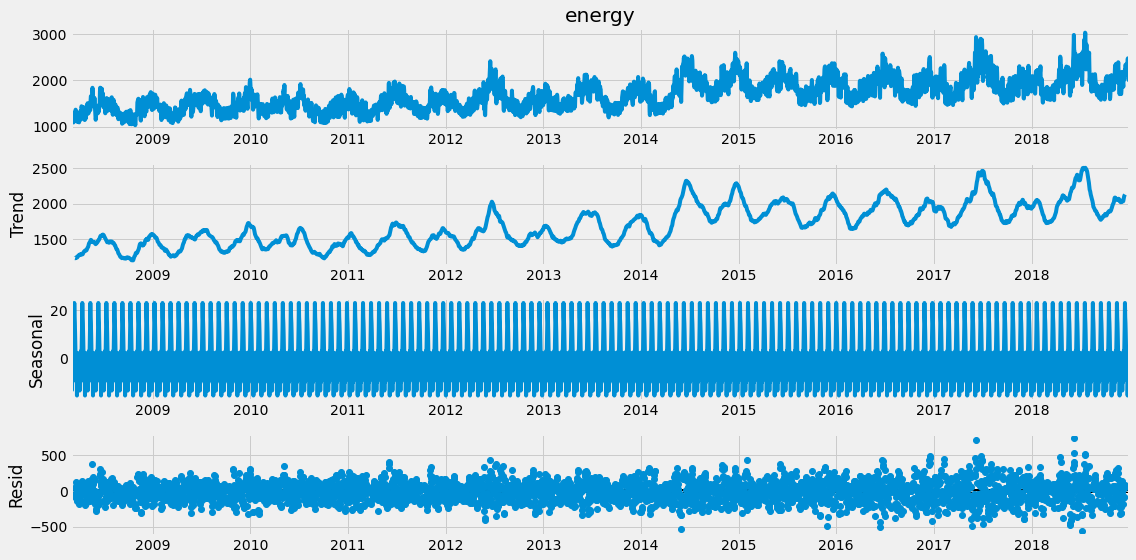

In [87]:
#Seasonality, noise and trend
decomposed_energy = sm.tsa.seasonal_decompose(df1['energy'], period = 30) # The frequncy is annual
figure = decomposed_energy.plot()
plt.show()

In [46]:
df1.shape

(3958, 9)

<AxesSubplot:xlabel='datetime'>

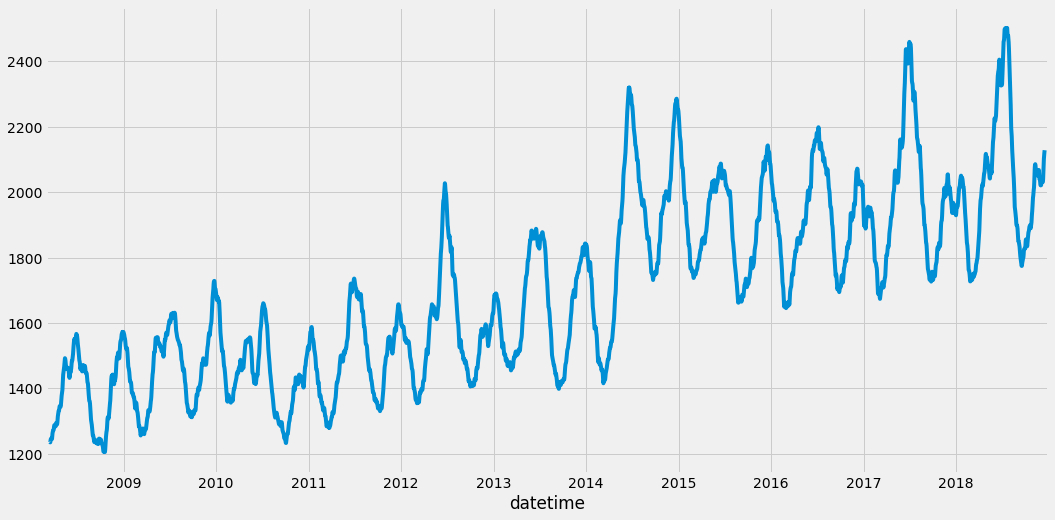

In [86]:
decomposed_energy.trend.plot()

<AxesSubplot:xlabel='datetime'>

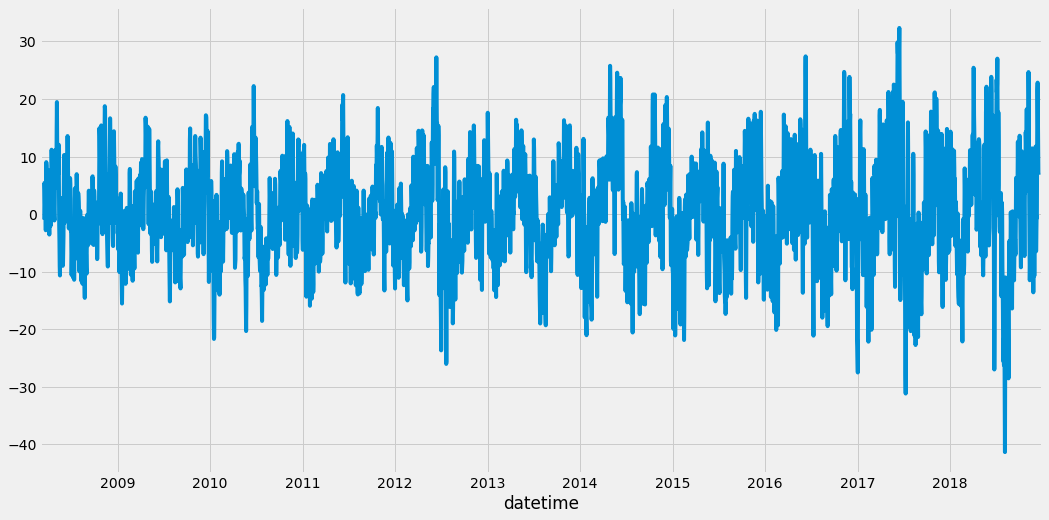

In [85]:
decomposed_energy.trend.diff().plot()

In [49]:
#ACF plot

def acf_plot(df,date,valcol,lag):
    plt.rc("figure", figsize=(16,8))
    x=train[[date,valcol]]
    x=x.dropna(axis=0)
    x.set_index(date,inplace=True)
    lag_acf = sm.graphics.tsa.plot_acf(x[valcol], lags=lag)
    plt.title(valcol)
    plt.xticks(range(52))

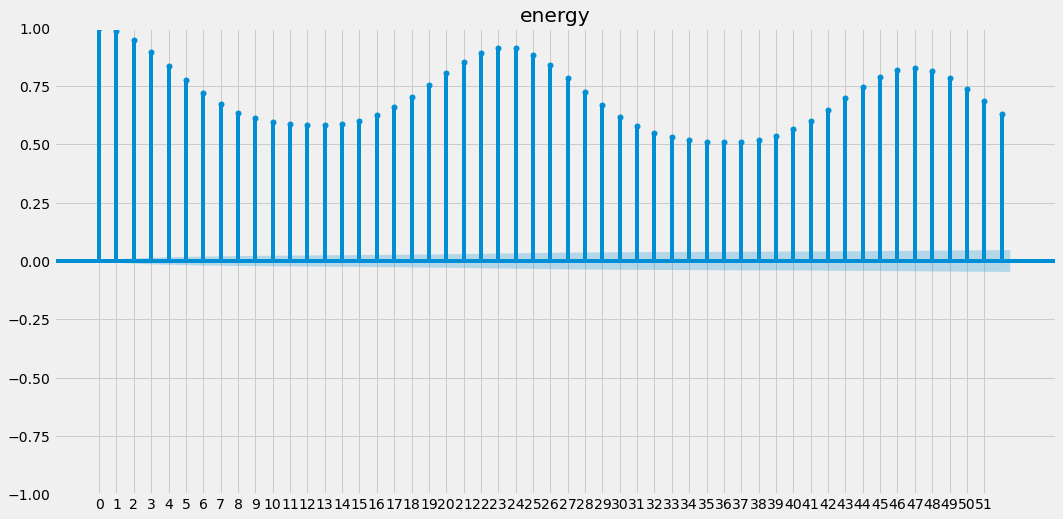

In [50]:
acf_plot(train,'datetime','energy',lag=52);


In [51]:
#PACF plot

def pacf_plot(df,date,valcol,lag):
    plt.rc("figure", figsize=(16,8))
    x=train[[date,valcol]]
    x=x.dropna(axis=0)
    x.set_index(date,inplace=True)
    lag_pacf = sm.graphics.tsa.plot_pacf(x[valcol], lags=lag)
    plt.title(valcol)
    plt.xticks(range(52))

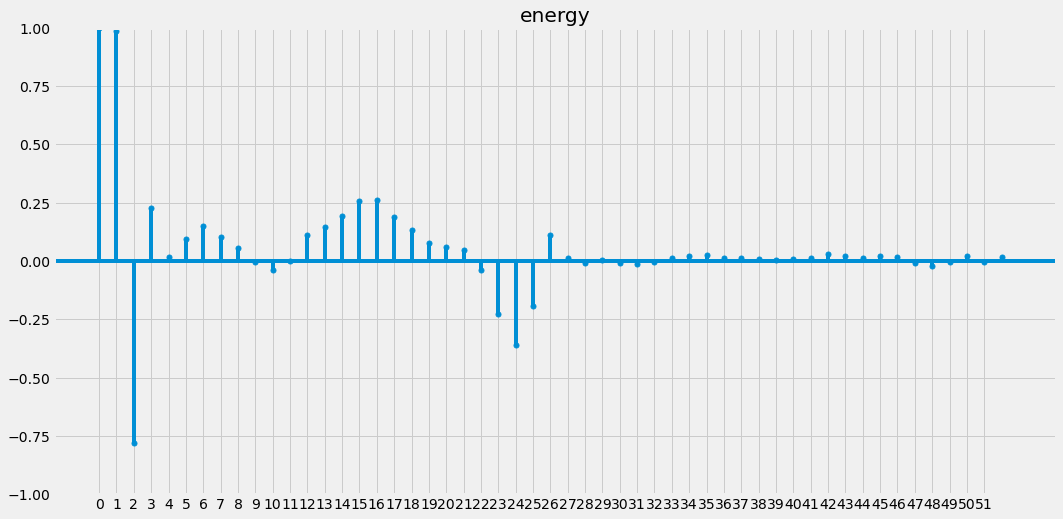

In [52]:
pacf_plot(train,'datetime','energy',lag=52)

In [53]:
#checking stationarity
from statsmodels.tsa.stattools import adfuller

In [54]:
adfuller(df1['energy'])

(-3.9453632326386066,
 0.001725236602194413,
 30,
 3927,
 {'1%': -3.4320163049810684,
  '5%': -2.862276282346099,
  '10%': -2.567161931577363},
 45972.90045405)

# SARIMAX

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3957
Model:               SARIMAX(4, 0, 4)   Log Likelihood              -23405.372
Date:                Sun, 19 Feb 2023   AIC                          46830.744
Time:                        18:33:46   BIC                          46893.577
Sample:                             0   HQIC                         46853.029
                               - 3957                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4181      3.313      0.126      0.900      -6.075       6.911
ar.L1          0.7968      0.002    328.748      0.000       0.792       0.802
ar.L2         -1.4383      0.002   -783.091      0.0

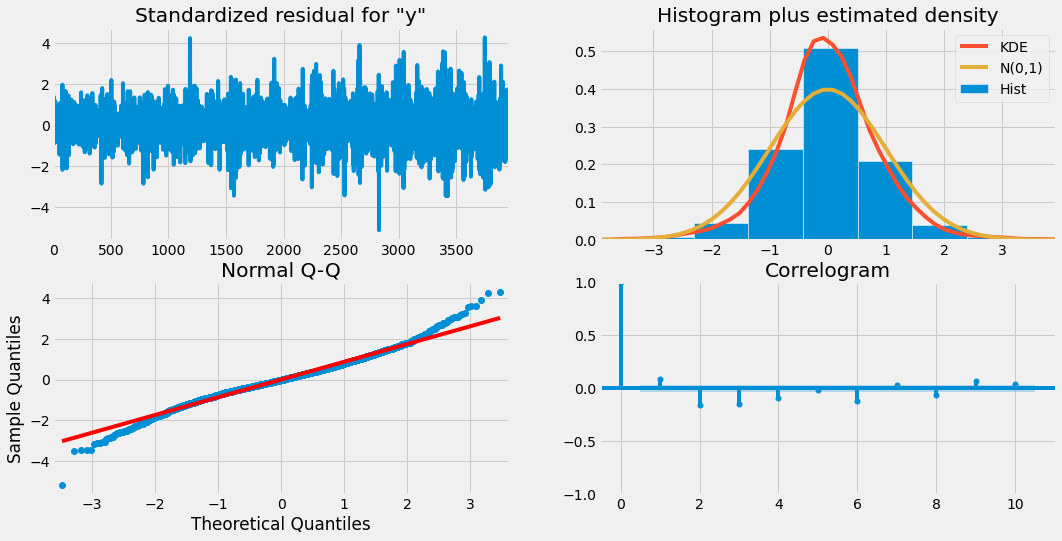

In [55]:
train_sample = df1['energy'].diff().iloc[1:].values
model = sm.tsa.SARIMAX(train_sample,order=(4,0,4),trend='c')
result = model.fit(maxiter=1000,disp=False)
print(result.summary())
predicted_result = result.predict(start=0, end=500)
result.plot_diagnostics();


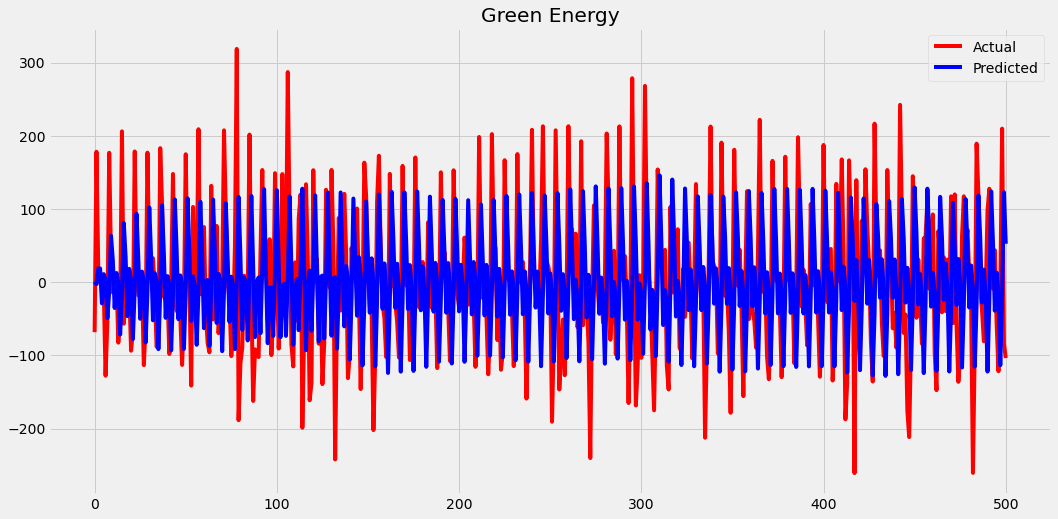

In [56]:
plt.plot(train_sample[1:502],color='red')
plt.plot(predicted_result,color='blue')
plt.legend(['Actual','Predicted'])
plt.title('Green Energy')
plt.show()

In [57]:
size = int(len(df)*0.9)
train_df = df1.iloc[:size]
test_df = df1.iloc[size:]

In [58]:
final_model = SARIMAX(df1['energy'],order=(1, 0, 1),seasonal_order=(1, 0, 2, 7),enforce_invertibility=False)
model_final = final_model.fit()
forecast = model_final.forecast(steps = 50)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.00877D+00    |proj g|=  2.25524D-01

At iterate    5    f=  5.94276D+00    |proj g|=  7.15616D-02

At iterate   10    f=  5.93944D+00    |proj g|=  7.58646D-03

At iterate   15    f=  5.92261D+00    |proj g|=  7.13571D-01

At iterate   20    f=  5.83740D+00    |proj g|=  5.74442D-02

At iterate   25    f=  5.83730D+00    |proj g|=  7.02558D-04

At iterate   30    f=  5.83637D+00    |proj g|=  4.42291D-02

At iterate   35    f=  5.81374D+00    |proj g|=  4.91790D-02

At iterate   40    f=  5.80952D+00    |proj g|=  7.09446D-02

At iterate   45    f=  5.80880D+00    |proj g|=  2.90763D-04

At iterate   50    f=  5.80877D+00    |proj g|=  7.14804D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

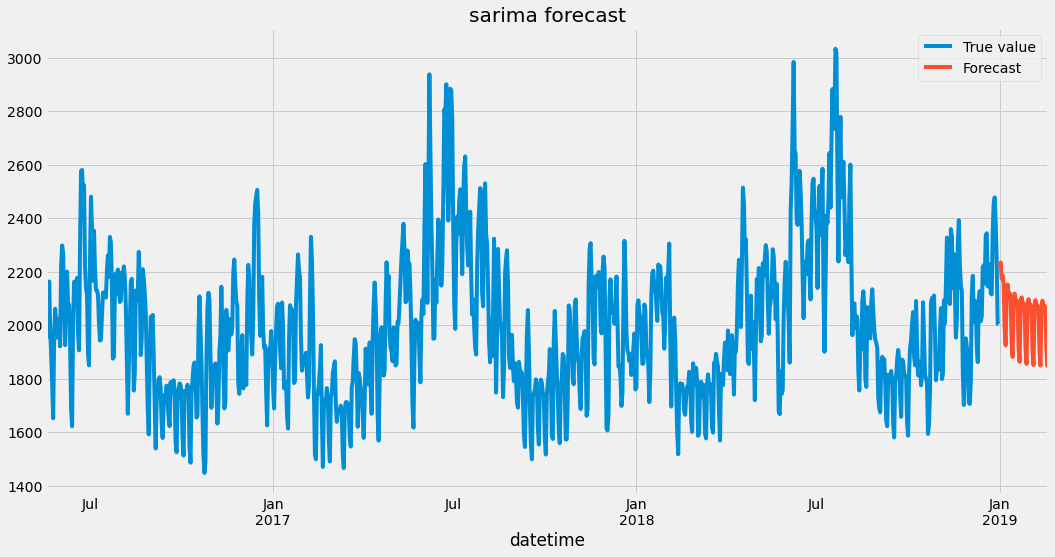

In [59]:
df1['energy'][3000:].plot(label = 'True value')
forecast.plot(label='Forecast')
plt.title("sarima forecast")
plt.legend()

In [60]:
df1.shape

(3958, 9)

In [61]:
from sklearn.metrics import mean_absolute_error as mae
from statsmodels.tools.eval_measures import rmse

## Evaluating

In [62]:
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(df1['energy'].diff().iloc[700:1001].values, result.predict(start=700,end=1000)))
print("The root mean squared error is {}.".format(rmse))


The root mean squared error is 114.27545123142505.


In [63]:
size = int(len(df1)*0.99)
train_df = df1.iloc[:size]
test_df = df1.iloc[size:]

In [64]:
df1.tail(3)

row_id       energy  Hour    year  month   day  day_of_week  \
datetime                                                                   
2018-12-29  94932.5  2234.698033  11.5  2018.0   12.0  29.0          5.0   
2018-12-30  94956.5  2004.926550  11.5  2018.0   12.0  30.0          6.0   
2018-12-31  94980.5  2002.238333  11.5  2018.0   12.0  31.0          0.0   

            is_quarter_date  is_weekend  
datetime                                 
2018-12-29              4.0         1.0  
2018-12-30              4.0         1.0  
2018-12-31              4.0         0.0

In [65]:
train_df.tail(3)

row_id       energy  Hour    year  month   day  day_of_week  \
datetime                                                                   
2018-11-19  93972.5  2020.822833  11.5  2018.0   11.0  19.0          0.0   
2018-11-20  93996.5  2312.178917  11.5  2018.0   11.0  20.0          1.0   
2018-11-21  94020.5  2392.251400  11.5  2018.0   11.0  21.0          2.0   

            is_quarter_date  is_weekend  
datetime                                 
2018-11-19              4.0         0.0  
2018-11-20              4.0         0.0  
2018-11-21              4.0         0.0

In [66]:
test_df.tail(3)

row_id       energy  Hour    year  month   day  day_of_week  \
datetime                                                                   
2018-12-29  94932.5  2234.698033  11.5  2018.0   12.0  29.0          5.0   
2018-12-30  94956.5  2004.926550  11.5  2018.0   12.0  30.0          6.0   
2018-12-31  94980.5  2002.238333  11.5  2018.0   12.0  31.0          0.0   

            is_quarter_date  is_weekend  
datetime                                 
2018-12-29              4.0         1.0  
2018-12-30              4.0         1.0  
2018-12-31              4.0         0.0

In [67]:
train_df.shape

(3918, 9)

In [68]:
test_df.shape

(40, 9)

# Auto arima to get the best order

In [ ]:
#Auto arima to get the best order
from pmdarima import auto_arima
energy_order1 = auto_arima(train_df['energy'],max_q=5,max_p=3,max_order=None,m=30,seasonal=True,trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[30] intercept   : AIC=47420.109, Time=31.31 sec
 ARIMA(0,1,0)(0,0,0)[30] intercept   : AIC=48671.478, Time=0.06 sec
 ARIMA(1,1,0)(1,0,0)[30] intercept   : AIC=48339.118, Time=5.79 sec
 ARIMA(0,1,1)(0,0,1)[30] intercept   : AIC=48203.514, Time=7.13 sec
 ARIMA(0,1,0)(0,0,0)[30]             : AIC=48669.500, Time=0.04 sec
 ARIMA(2,1,2)(0,0,1)[30] intercept   : AIC=47449.873, Time=25.39 sec
 ARIMA(2,1,2)(1,0,0)[30] intercept   : AIC=47459.296, Time=26.33 sec
 ARIMA(2,1,2)(2,0,1)[30] intercept   : AIC=inf, Time=207.83 sec
 ARIMA(2,1,2)(1,0,2)[30] intercept   : AIC=inf, Time=244.66 sec
 ARIMA(2,1,2)(0,0,0)[30] intercept   : AIC=47537.604, Time=2.16 sec
 ARIMA(2,1,2)(0,0,2)[30] intercept   : AIC=47439.493, Time=195.00 sec


In [70]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3958 entries, 2008-03-01 to 2018-12-31
Freq: D
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   row_id           3958 non-null   float64
 1   energy           3958 non-null   float64
 2   Hour             3958 non-null   float64
 3   year             3958 non-null   float64
 4   month            3958 non-null   float64
 5   day              3958 non-null   float64
 6   day_of_week      3958 non-null   float64
 7   is_quarter_date  3958 non-null   float64
 8   is_weekend       3958 non-null   float64
dtypes: float64(9)
memory usage: 309.2 KB


In [71]:
start_date = test_df.index[0]
end_date = test_df.index[-1]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.89624D+04    |proj g|=  1.50253D+05

At iterate    5    f=  6.25952D+01    |proj g|=  1.38976D+02


 This problem is unconstrained.



At iterate   10    f=  9.94525D+00    |proj g|=  5.59617D+00

At iterate   15    f=  6.34298D+00    |proj g|=  2.07424D-01

At iterate   20    f=  6.18216D+00    |proj g|=  1.23508D-02

At iterate   25    f=  6.17604D+00    |proj g|=  5.15125D-03

At iterate   30    f=  6.08932D+00    |proj g|=  3.61786D-02

At iterate   35    f=  6.08135D+00    |proj g|=  1.11985D-02

At iterate   40    f=  6.08080D+00    |proj g|=  4.55315D-03

At iterate   45    f=  6.07619D+00    |proj g|=  3.70988D-02

At iterate   50    f=  6.07106D+00    |proj g|=  3.90268D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     64   

<AxesSubplot:>

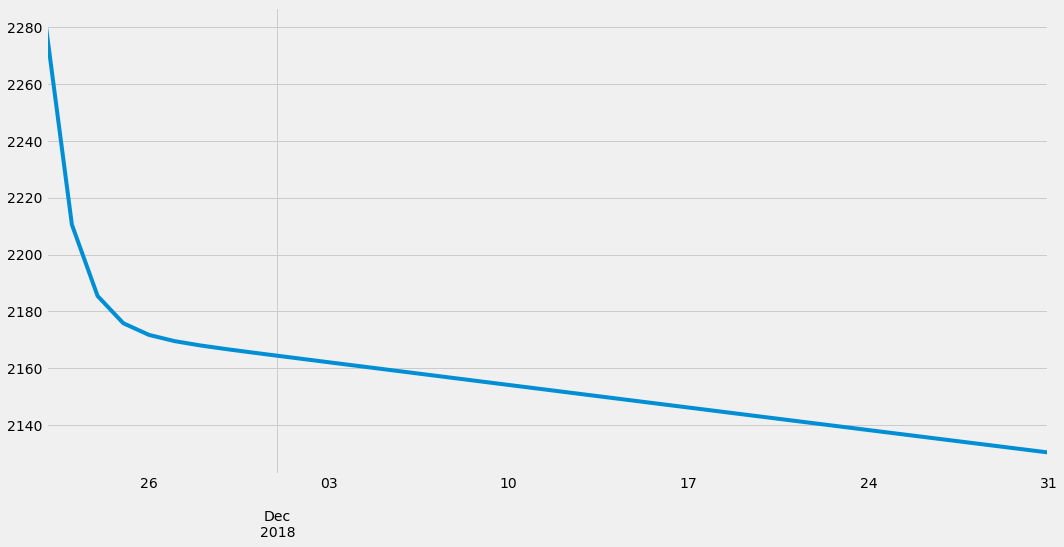

In [72]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model=SARIMAX(train_df['energy'],order=(2,0,2))
model_fit=model.fit()
model_fit.summary()
pred = model_fit.predict(start=start_date,end=end_date)
pred.plot()

# Evaluating

In [ ]:
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(df1['energy'].diff().iloc[700:1001].values, result.predict(start=700,end=1000)))
print("The root mean squared error is {}.".format(rmse))

# Prophet

In [73]:
from prophet import Prophet

In [74]:
p_data = pd.DataFrame({'y':df1['energy'], 'ds': df1.index})

In [75]:
p_data.head()

y         ds
datetime                          
2008-03-01  1264.005398 2008-03-01
2008-03-02  1150.488938 2008-03-02
2008-03-03  1082.096875 2008-03-03
2008-03-04  1260.189978 2008-03-04
2008-03-05  1277.914188 2008-03-05

In [76]:
train = p_data.iloc[:size]
test = p_data.iloc[size:]

In [77]:
prophet_model = Prophet(weekly_seasonality=True,seasonality_mode='additive')
prophet_model.fit(train)

18:34:27 - cmdstanpy - INFO - Chain [1] start processing
18:34:27 - cmdstanpy - INFO - Chain [1] done processing


In [78]:
forecast_date = prophet_model.make_future_dataframe(periods=36,freq='D')
prophet_predict = prophet_model.predict(forecast_date)
prophet_predict.head()

ds        trend   yhat_lower   yhat_upper  trend_lower  trend_upper  \
0 2008-03-01  1342.357922  1002.120183  1336.552741  1342.357922  1342.357922   
1 2008-03-02  1342.594471   866.568388  1208.582473  1342.594471  1342.594471   
2 2008-03-03  1342.831020   826.847748  1170.193235  1342.831020  1342.831020   
3 2008-03-04  1343.067569  1002.470203  1341.106145  1343.067569  1343.067569   
4 2008-03-05  1343.304118  1041.632404  1381.033324  1343.304118  1343.304118   

   additive_terms  additive_terms_lower  additive_terms_upper      weekly  \
0     -169.692081           -169.692081           -169.692081   29.736645   
1     -300.797973           -300.797973           -300.797973  -98.885917   
2     -348.662332           -348.662332           -348.662332 -144.341018   
3     -173.876503           -173.876503           -173.876503   32.736702   
4     -145.106347           -145.106347           -145.106347   63.629283   

   weekly_lower  weekly_upper      yearly  yearly_lower  yearly_upper  \
0     29.736645     29.736645 -199.428726   -199.428726   -199.428726   
1    -98.885917    -98.885917 -201.912056   -201.912056   -201.912056   
2   -144.341018   -144.341018 -204.321314   -204.321314   -204.321314   
3     32.736702     32.736702 -206.613205   -206.613205   -206.613205   
4     63.629283     63.629283 -208.735630   -208.735630   -208.735630   

   multiplicative_terms  multiplicative_terms_lower  \
0                   0.0                         0.0   
1                   0.0                         0.0   
2                   0.0                         0.0   
3                   0.0                         0.0   
4                   0.0                         0.0   

   multiplicative_terms_upper         yhat  
0                         0.0  1172.665841  
1                         0.0  1041.796497  
2                         0.0   994.168688  
3                         0.0  1169.191066  
4                         0.0  1198.197771

In [79]:
prophet_model = Prophet()
prophet_model.fit(p_data)

18:34:32 - cmdstanpy - INFO - Chain [1] start processing
18:34:32 - cmdstanpy - INFO - Chain [1] done processing


In [80]:
forecast_date2 = prophet_model.make_future_dataframe(periods=30,freq='D')
prophet_predict2 = prophet_model.predict(forecast_date2)

# Test vs Prediction

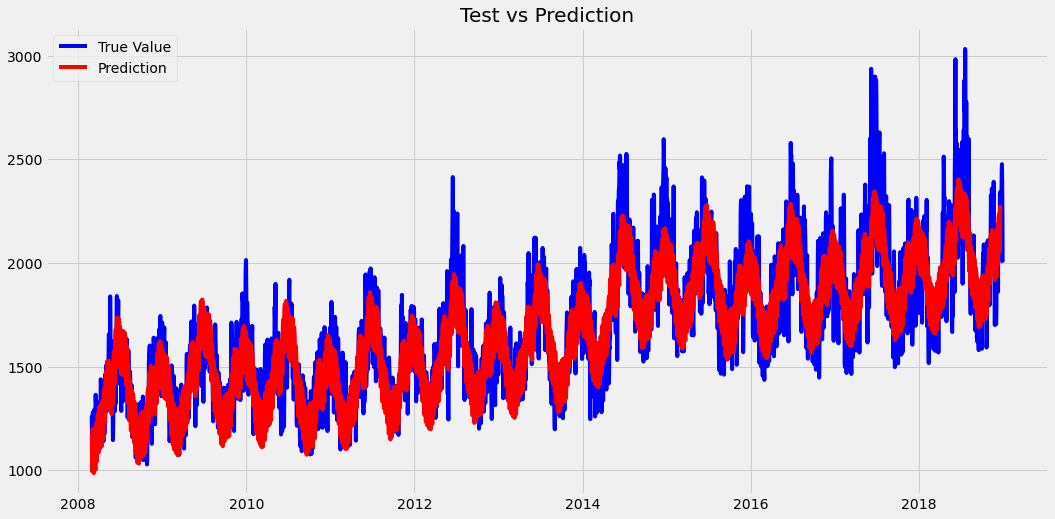

In [81]:
plt.plot(p_data['ds'], p_data['y'], 'b', label='True Value')
plt.plot(prophet_predict2['ds'][:-40], prophet_predict2['yhat'][:-40], 'r', label='Prediction')
plt.legend()
plt.title('Test vs Prediction',size = 20)
plt.show()

In [82]:
from prophet.plot import plot_components_plotly

In [83]:
plot_components_plotly(prophet_model , prophet_predict2)

# Prophet Forecast

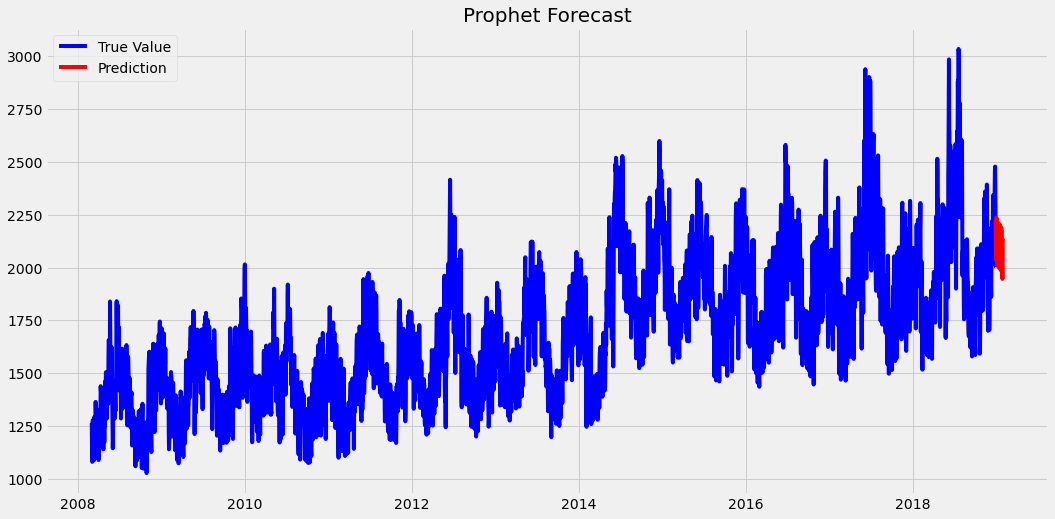

In [84]:
plt.plot(p_data['ds'], p_data['y'], 'b', label='True Value')
plt.plot(prophet_predict2['ds'][-33:], prophet_predict2['yhat'][-33:], 'r', label='Prediction')
plt.legend()
plt.title('Prophet Forecast',size = 20)
plt.show()